# Preparation

In [1]:
## Enable matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

## Imports
import pandas as pd
pd.set_option('mode.chained_assignment',None)
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import numpy as np
from sklearn.cluster import DBSCAN

## Define functions

In [2]:
import math

## --------------------------------------------------
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    
    sklearn implementation
    2 arcsin(sqrt(sin^2(0.5*dx)cos(x1)cos(x2)sin^2(0.5*dy)))
    
    
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [3]:
## --------------------------------------------------
def trip_work(trip):
    """
    Calculates the score for a trip
    """
    
    work = 0.0
    total_weight = 10.0 + trip['Weight'].sum()
    lon = 0
    lat = 90
    
    for i, row in trip.iterrows():
        current_lon = row['Longitude']
        current_lat = row['Latitude']
        current_w   = row['Weight']
        
        distance = haversine(lon, lat, current_lon, current_lat)
        work += distance * total_weight
        
        total_weight -= current_w
        lon = current_lon
        lat = current_lat
        
    work += haversine(lon, lat, 0, 90) * 10.0
    
    return work
        

In [4]:
## --------------------------------------------------
def make_trips(df, maxd=1.0):
    """
    Make the trips by longitudinal binning and latitude ordering
    """
    
    df = df.sort_values(by='Longitude')
    
    ## Bin the longitude axis such that every bin sums up to 990 pounds
    trip_numbers = []
    trip_number = 1
    weight = 10.0
    longitude = gifts_df['Longitude'].values[0]
    max_delta_longitude = maxd

    for i, row in df.iterrows():
        current_weight = row['Weight']
        current_longitude = row['Longitude']
        if (weight + current_weight > 1000.0) or (current_longitude - longitude > max_delta_longitude):
            trip_number += 1
            weight = 10.0 + current_weight
            longitude = current_longitude
        else:
            weight += current_weight
        trip_numbers.append((row['GiftId'], trip_number))
    
    trip_numbers = np.array(trip_numbers, dtype=int)
    
    trip_numbers = pd.DataFrame(trip_numbers, columns=['GiftId', 'TripId'])
    
    df = pd.merge(df, trip_numbers)
    
    df = df.sort_values(by=['TripId','Latitude'], ascending=[True,False])
    
    return df

In [5]:
## --------------------------------------------------
def score(df):
    """
    Calculates the total score on the entire dataset
    """
    
    n = df['TripId'].max()
    x = 0
    for i in range(1, n+1):
        trip = df[df['TripId'] == i]
        x += trip_work(trip)
    return x, n

# Load

In [6]:
## Load data
gifts_df = pd.read_csv('gifts.csv')

## Convert longitude and latitude to radians in new columns
gifts_df['lon_rad'] = np.deg2rad(gifts_df['Longitude'].values)
gifts_df['lat_rad'] = np.deg2rad(gifts_df['Latitude'].values)

# Clustering

In [7]:
## Frame the DBSCAN parameters in terms of the problem
earth_radius = 6371.0   # km
minimum_distance = 750.0 # km
eps = minimum_distance/earth_radius

## Do the clustering
clustering = DBSCAN(eps=eps, min_samples=5, metric='haversine')
gifts_df['cluster'] = clustering.fit_predict(gifts_df[['lat_rad', 'lon_rad']].values)

In [8]:
## Making Antarctica into one cluster, everything else together
m = {-1:0, 0:0, 1:1, 2:0, 3:0, 4:0, 5:0}
gifts_df['cluster'] = gifts_df['cluster'].map(m)

# Longitudinal binning

In [9]:
clusters = []
n_gifts_covered = 0

## Partition the dataframe in clusters
for i in range(2):
    cluster = gifts_df[gifts_df['cluster'] == i]
    cluster = make_trips(cluster, maxd=360.0)
    cluster['TripId'] = cluster['TripId'] + n_gifts_covered
    n_gifts_covered = cluster['TripId'].max()
    clusters.append(cluster)
    
gifts_df = pd.concat(clusters)

In [10]:
## Evaluate final score
x,n = score(gifts_df)
print 'Score:', x, 'in', n, 'trips'

Score: 12527494345.7 in 1446 trips


# Optimization Loop

In [ ]:
dlon = 0

best_score = [float('inf'), float('inf')]
best_shift = [0,0]

for d in range(100):
    
    df = gifts_df[:]
    
    n_gifts_covered = 0

    ## Partition the dataframe in clusters
    for i in range(2):
        cluster = df[df['cluster'] == i]
        
        ## Shift longitude
        cluster.sort_values(by='Longitude', inplace=True)
        cluster['Longitude'] = (cluster['Longitude'] + 180.0) % 360.0
        cluster.sort_values(by='Longitude', inplace=True)
        
        cluster['Longitude'] = (cluster['Longitude'] + dlon) % 360.0
        cluster.sort_values(by='Longitude', inplace=True)
        
        cluster = make_trips(cluster, maxd=360)
        
        dlon += 360 - cluster['Longitude'].values[-1]
        
        ## Evaluate final score
        x,n = score(cluster)
        print 'Cluster:', i, 'Shift:', d, 'Score:', x, 'in', n, 'trips'
        
        if x < best_score[i]:
            best_score[i] = x
            best_shift[i] = d
            
    print '-'*50
    print 'Best scores so far:'
    print 'cluster 0:', best_score[0], 'for shift', best_shift[0]
    print 'cluster 1:', best_score[1], 'for shift', best_shift[1]
    print 'Total:', best_score[0] + best_score[1]
    print

# Optimize Individual Trips

In [11]:
import time
n = len(gifts_df['TripId'].unique())
cumulative_improvement = 0

for i in xrange(1,n+1):
    
    start_time = time.time()
    
    ## Obtain trip and calculate the initial work
    trip = gifts_df[gifts_df['TripId'] == i]
    initial_trip_work = trip_work(trip)
    
    ## Give optimization priority to heavier weights that are further down
    trip.sort_values(by=['Weight', 'Latitude'], ascending=[False,True], inplace=True)
    
    ## Start the revised trip with the first entry, make a list of the gifts to append
    revised_trip = trip[:1]
    rest_trip = trip[1:]
    
    ## Make an order row
    n_revised = 1
    revised_trip['order'] = np.arange(1,n_revised+1)
    
    for index, row in rest_trip.iterrows():
        ## Generate intermediary indices for the difference insertion positions
        inserts = [j+0.5 for j in xrange(n_revised+1)]
        row_df = row.to_frame().transpose()
    
        best_work = float('inf')
        best_trip = None
    
        for k in inserts:
            row_df['order'] = k
            test_trip = pd.concat([revised_trip, row_df])
            test_trip = test_trip.sort_values(by='order')
            work = trip_work(test_trip)
            if work < best_work:
                best_work = work
                best_trip = test_trip
            
        revised_trip = best_trip
        n_revised = len(revised_trip)
        revised_trip['order'] = np.arange(1,n_revised+1)    
    
    ## Calculate the final trip work and the cumulative improvement
    final_trip_work = trip_work(revised_trip)
    
    if final_trip_work < initial_trip_work:
        cumulative_improvement += initial_trip_work - final_trip_work
        
        ## Put the trip back into the gifts DF
        del revised_trip['order']
        gifts_df[gifts_df['TripId'] == i] = revised_trip.values
        
    else:
        print 'Failed at improving:', initial_trip_work - final_trip_work
        
    end_time = time.time()
    print 'Trip', i, 'cumulative improvement so far:', cumulative_improvement, 'dt:', end_time - start_time
    

Trip 1 cumulative improvement so far: 1439652.02601 dt: 9.88713288307
Trip 2 cumulative improvement so far: 3861326.87462 dt: 12.0920000076
Trip 3 cumulative improvement so far: 4384873.66105 dt: 7.38640904427
Trip 4 cumulative improvement so far: 4533400.32719 dt: 5.21082115173
Trip 5 cumulative improvement so far: 4730686.57331 dt: 5.41801691055
Trip 6 cumulative improvement so far: 4865845.37375 dt: 11.1411180496
Trip 7 cumulative improvement so far: 4877380.26431 dt: 5.79360699654
Trip 8 cumulative improvement so far: 4889892.2951 dt: 5.78352689743
Trip 9 cumulative improvement so far: 4969294.63456 dt: 10.7124021053
Trip 10 cumulative improvement so far: 5503430.01118 dt: 10.5196402073
Trip 11 cumulative improvement so far: 5664594.90368 dt: 6.88780593872
Trip 12 cumulative improvement so far: 5848853.77547 dt: 6.57280087471
Trip 13 cumulative improvement so far: 6477011.60329 dt: 9.58771085739
Trip 14 cumulative improvement so far: 7231912.39204 dt: 10.5763239861
Trip 15 cumulati

# Evaluate Final Score

In [12]:
## Evaluate final score
x,n = score(gifts_df)
print 'Score:', x, 'in', n, 'trips'

# beat 12490230556.01350

Score: 12485462246.6 in 1446 trips


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


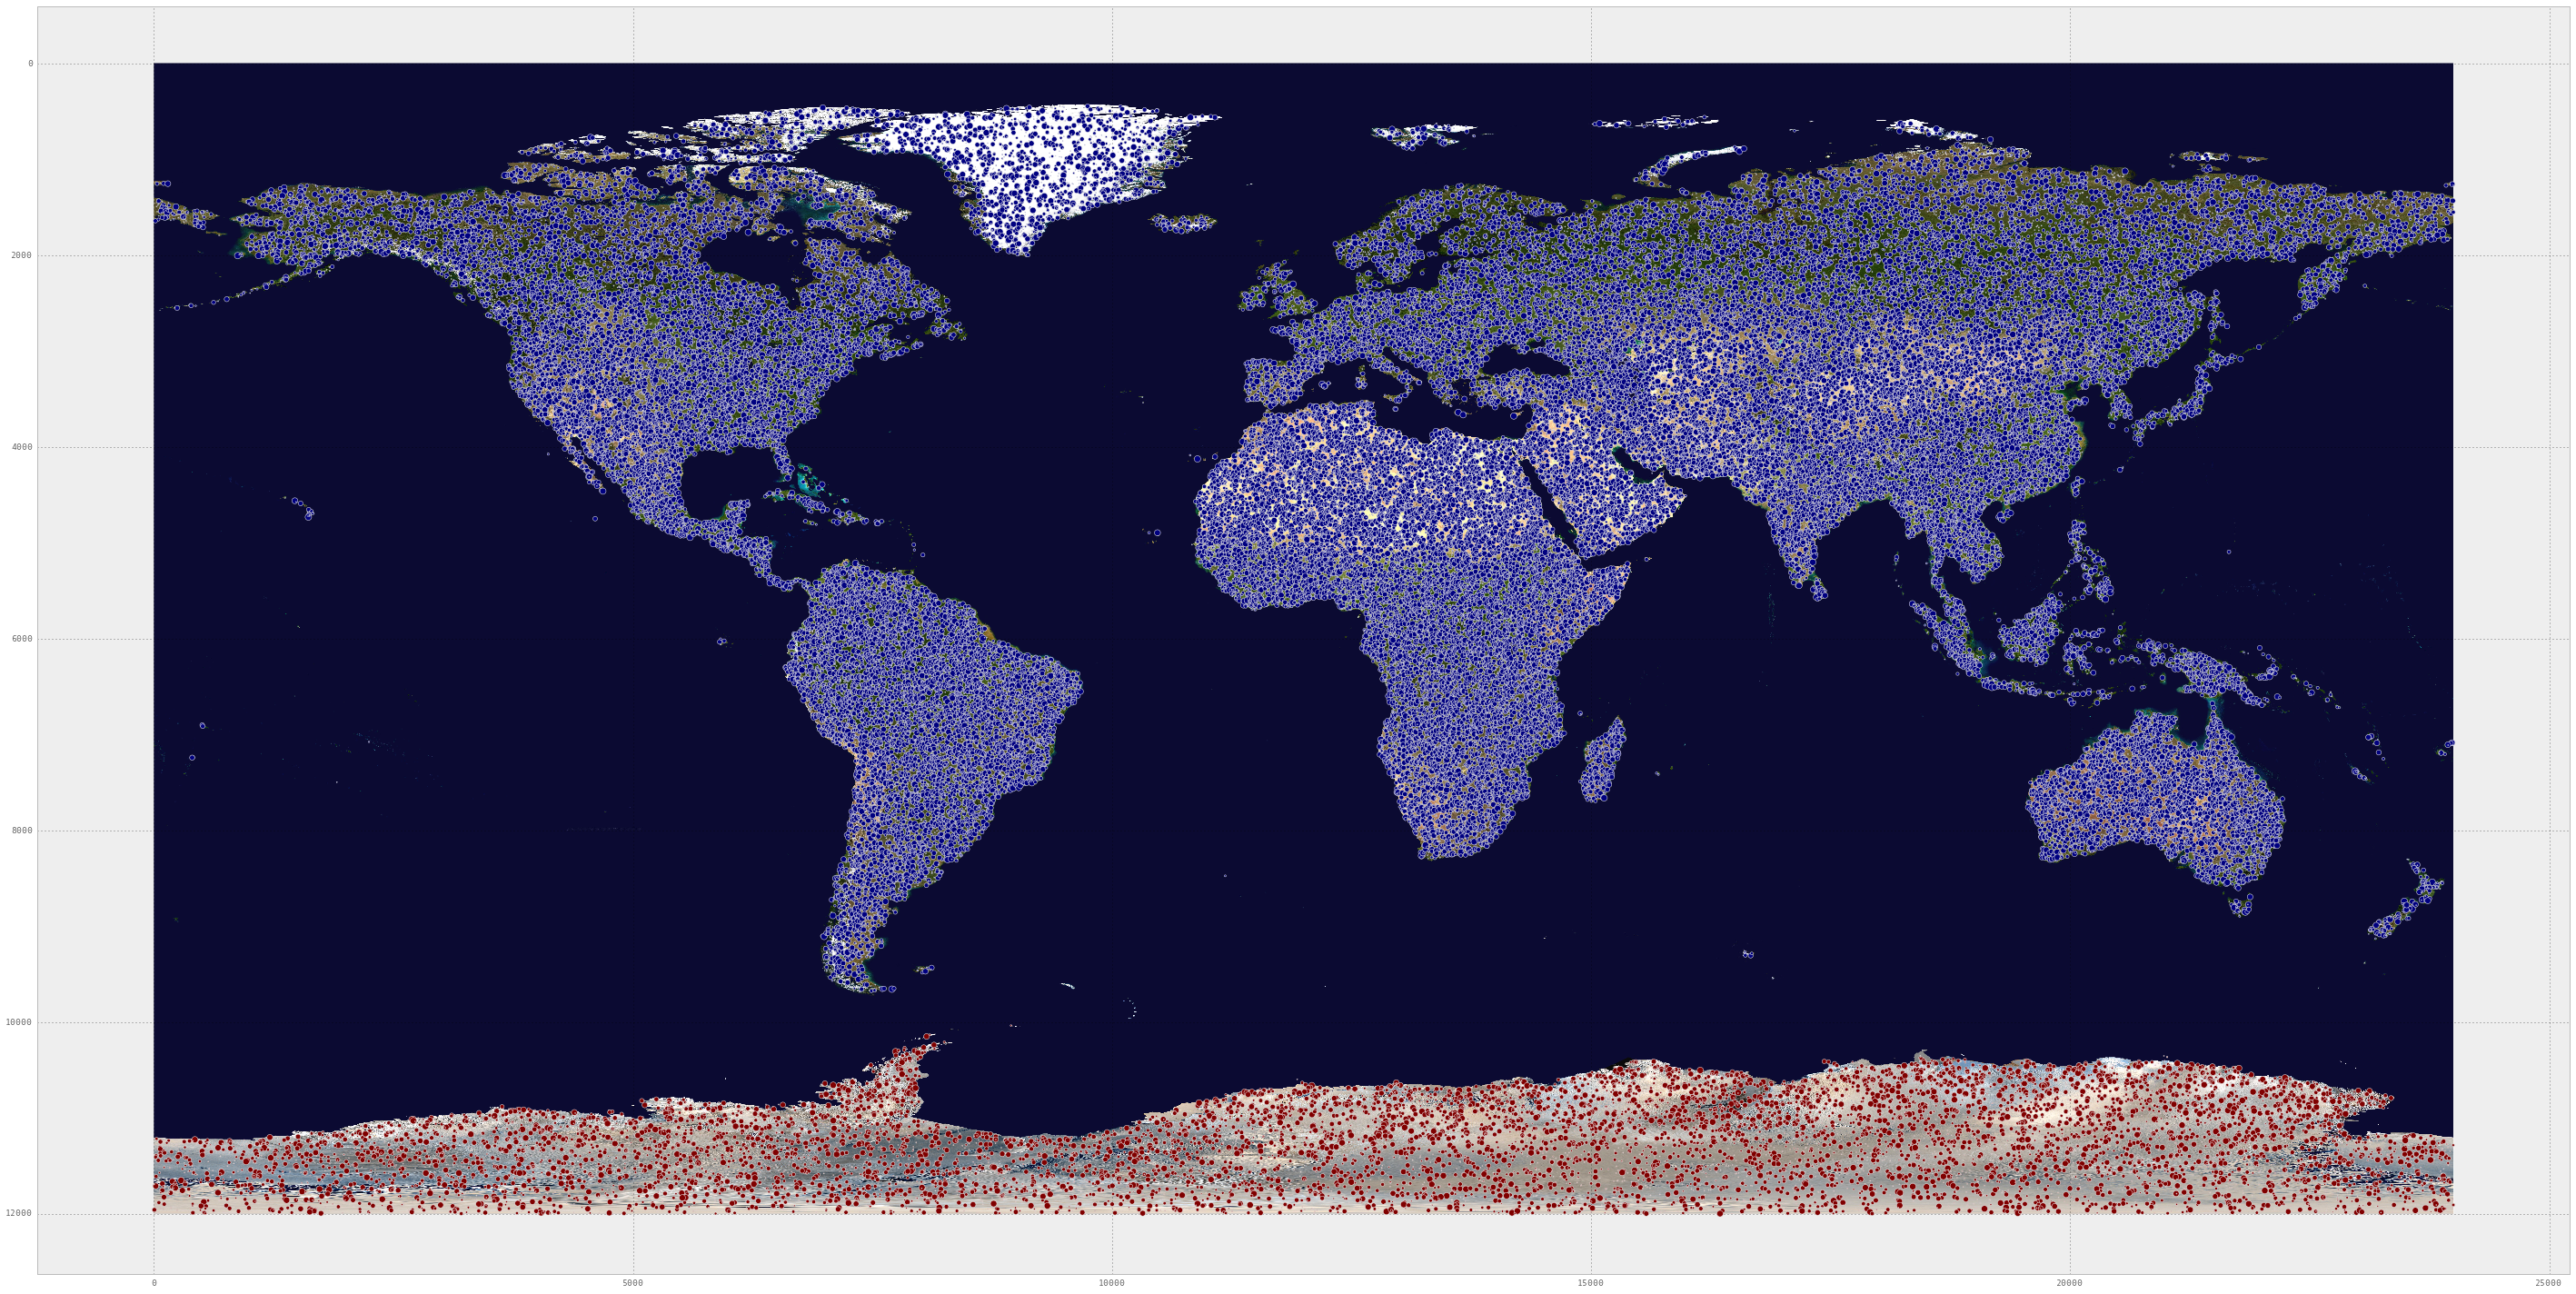

In [ ]:
from cv2 import imread, cvtColor, COLOR_BGR2RGB

## ----------------------------------------------
def read_image(path):
    """
    Read an image and convert to RGB using openCV
    """
    img = imread(path)
    return cvtColor(img, COLOR_BGR2RGB)

## ----------------------------------------------
def transform(x,y):
    """
    transform the latitude/longitude coordinates to the coordinates of the image
    """
    
    new_x = (x + 180)*(earth.shape[1]/360.0)
    new_y = -(y - 90)*(earth.shape[0]/180.0)
    
    return new_x, new_y

## Load earth background
earth = read_image('earth.jpg')

## Get gift data from dataframe
x = gifts_df['Longitude'].values
y = gifts_df['Latitude'].values
w = gifts_df['Weight'].values
c = gifts_df['cluster'].values +5

x_, y_ = transform(x,y)

plt.figure(figsize=(50,25))
plt.imshow(earth)
plt.scatter(x_, y_, s=w, c=c)

In [ ]:
import random
from matplotlib import colors

c = colors.cnames.keys()

fig = plt.figure(frameon=False)
fig.set_size_inches(120,60)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(earth, aspect='normal')

n_trips = gifts_df['TripId'].max()
for i in range(1, n_trips+1):
    trip = gifts_df[gifts_df['TripId'] == i]
    
    x = trip['Longitude'].values
    y = trip['Latitude'].values
    
    x_, y_ = transform(x,y)
    ax.plot(x_,y_,c=random.choice(c))
        
fig.savefig('trips.png')

In [ ]:
trips_df = gifts_df[['GiftId', 'TripId']]
trips_df.to_csv('trips.csv', index=False)